# PROYECTO FINAL CASOS DE GRIPE

# Introducción al Modelo de Predicción y Clasificación de Brotes de Gripe

En este proyecto desarrollaremos un modelo de Machine Learning híbrido enfocado en la vigilancia y análisis predictivo de la gripe estacional en Estados Unidos, integrando datos clínicos del sistema FluView y variables climáticas históricas. El modelo tiene un doble propósito:

* Objetivos:  

Predicción Continua de Casos de Gripe (num_ili y wili):
Estimamos el número esperado de casos semanales de enfermedades tipo influenza (ILI) a nivel regional, utilizando como variables predictoras tanto características clínicas como condiciones climáticas (temperatura media y aparente).

Clasificación del Riesgo de Brote:
A partir de la predicción de wili, clasificamos cada semana como riesgo bajo o alto de brote gripal, permitiendo identificar periodos críticos para la salud pública.

## 1) TRATAMIENTO DE LOS DATOS

### Juntar las bases de datos FlueView y FlueView Clinical 

In [1]:
# Cargar el archivo con la informacion de salud de un CSV en un DataFrame
import pandas as pd                                         

# Cargar los archivos
df1 = pd.read_csv("/workspaces/Proyecto_Final_Salud/data/raw/fluview_data.csv")
df2 = pd.read_csv("/workspaces/Proyecto_Final_Salud/data/raw/fluview_clinical_data.csv")

# Unir los dos DataFrames en uno solo
df_combined = pd.concat([df1, df2], ignore_index=True)

In [2]:
# Diccionario de regiones HHS
hhs_regions = {
    "hhs1": "Región 1", "hhs2": "Región 2", "hhs3": "Región 3", "hhs4": "Región 4",
    "hhs5": "Región 5", "hhs6": "Región 6", "hhs7": "Región 7", "hhs8": "Región 8",
    "hhs9": "Región 9", "hhs10": "Región 10"
}

# Diccionario de estados y su región HHS
state_to_hhs = {
    "CT": "HHS1", "ME": "HHS1", "MA": "HHS1", "NH": "HHS1", "RI": "HHS1", "VT": "HHS1",
    "NJ": "HHS2", "NY": "HHS2", "PR": "HHS2", "VI": "HHS2",
    "DE": "HHS3", "DC": "HHS3", "MD": "HHS3", "PA": "HHS3", "VA": "HHS3", "WV": "HHS3",
    "AL": "HHS4", "FL": "HHS4", "GA": "HHS4", "KY": "HHS4", "MS": "HHS4", "NC": "HHS4", "SC": "HHS4", "TN": "HHS4",
    "IL": "HHS5", "IN": "HHS5", "MI": "HHS5", "MN": "HHS5", "OH": "HHS5", "WI": "HHS5",
    "AR": "HHS6", "LA": "HHS6", "NM": "HHS6", "OK": "HHS6", "TX": "HHS6",
    "IA": "HHS7", "KS": "HHS7", "MO": "HHS7", "NE": "HHS7",
    "CO": "HHS8", "MT": "HHS8", "ND": "HHS8", "SD": "HHS8", "UT": "HHS8", "WY": "HHS8",
    "AZ": "HHS9", "CA": "HHS9", "HI": "HHS9", "NV": "HHS9", "AS": "HHS9", "GU": "HHS9", "MP": "HHS9",
    "AK": "HHS10", "ID": "HHS10", "OR": "HHS10", "WA": "HHS10"
}

# Crear nueva columna 'Region Nombre'
df_combined["Region Nombre"] = df_combined["region"].map(hhs_regions).fillna(df_combined["region"])

# Reemplazar abreviaturas de estados con nombres completos
us_states = {
    "AZ": "Arizona", "CA": "California", "TX": "Texas", "NY": "New York", "FL": "Florida",
    "IL": "Illinois", "PA": "Pennsylvania", "OH": "Ohio", "MI": "Michigan", "GA": "Georgia",
    "NC": "North Carolina", "NJ": "New Jersey", "VA": "Virginia", "WA": "Washington", "MA": "Massachusetts",
    "IN": "Indiana", "TN": "Tennessee", "MO": "Missouri", "MD": "Maryland", "WI": "Wisconsin",
    "CO": "Colorado", "MN": "Minnesota", "SC": "South Carolina", "AL": "Alabama", "LA": "Louisiana",
    "KY": "Kentucky", "OR": "Oregon", "OK": "Oklahoma", "CT": "Connecticut", "IA": "Iowa",
    "MS": "Mississippi", "AR": "Arkansas", "UT": "Utah", "NV": "Nevada", "NM": "New Mexico",
    "WV": "West Virginia", "NE": "Nebraska", "ID": "Idaho", "HI": "Hawaii", "ME": "Maine",
    "NH": "New Hampshire", "MT": "Montana", "RI": "Rhode Island", "DE": "Delaware",
    "SD": "South Dakota", "ND": "North Dakota", "AK": "Alaska", "VT": "Vermont", "WY": "Wyoming",
    "DC": "Washington D.C.", "PR": "Puerto Rico", "VI": "Virgin Islands", "GU": "Guam", "MP": "Northern Mariana Islands",
    "AS": "American Samoa"
}

df_combined["Region Nombre"] = df_combined["Region Nombre"].replace(us_states)

# Crear nueva columna 'Region HHS'
df_combined["Region HHS"] = df_combined["region"].map(state_to_hhs).fillna(df_combined["region"].map(hhs_regions))

# Mostrar las primeras filas para verificar
df_combined.head()

,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,...,wili,ili,total_specimens,total_a,total_b,percent_positive,percent_a,percent_b,Region Nombre,Region HHS
0,2013-12-31,hhs1,201352,201001,207,276.0,31688.0,138.0,83.0,101.0,...,0.781852,0.870992,NaN,NaN,NaN,NaN,NaN,NaN,Región 1,Región 1
1,2013-12-31,hhs10,201352,201001,207,193.0,15093.0,58.0,67.0,69.0,...,1.129034,1.278738,NaN,NaN,NaN,NaN,NaN,NaN,Región 10,Región 10
2,2013-12-31,hhs2,201352,201001,207,2342.0,109987.0,188.0,948.0,636.0,...,1.689027,2.129343,NaN,NaN,NaN,NaN,NaN,NaN,Región 2,Región 2
3,2013-12-31,hhs3,201352,201001,207,2114.0,97052.0,225.0,527.0,584.0,...,1.981594,2.178214,NaN,NaN,NaN,NaN,NaN,NaN,Región 3,Región 3
4,2013-12-31,hhs4,201352,201001,207,3052.0,145117.0,440.0,1229.0,893.0,...,1.675217,2.103131,NaN,NaN,NaN,NaN,NaN,NaN,Región 4,Región 4


In [3]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68397 entries, 0 to 68396
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   release_date      67711 non-null  object 
 1   region            68397 non-null  object 
 2   issue             68397 non-null  int64  
 3   epiweek           68397 non-null  int64  
 4   lag               68397 non-null  int64  
 5   num_ili           45341 non-null  float64
 6   num_patients      45341 non-null  float64
 7   num_providers     45341 non-null  float64
 8   num_age_0         8701 non-null   float64
 9   num_age_1         8701 non-null   float64
 10  num_age_2         0 non-null      float64
 11  num_age_3         8701 non-null   float64
 12  num_age_4         8701 non-null   float64
 13  num_age_5         8701 non-null   float64
 14  wili              45341 non-null  float64
 15  ili               45341 non-null  float64
 16  total_specimens   23056 non-null  float6

### Añadir los datos historicos de temperatura

In [4]:
# Cargar DataFrame con el historico de datos de temperatura
import pandas as pd                                         

df_temp = pd.read_csv("/workspaces/Proyecto_Final_Salud/data/raw/temperaturas_estados_usa.csv")

#Crea la columna region en df_temp
state_abbrev = {
    'Alabama': 'al', 'Alaska': 'ak', 'Arizona': 'az', 'Arkansas': 'ar',
    'California': 'ca', 'Colorado': 'co', 'Connecticut': 'ct', 'Delaware': 'de',
    'Florida': 'fl', 'Georgia': 'ga', 'Hawaii': 'hi', 'Idaho': 'id',
    'Illinois': 'il', 'Indiana': 'in', 'Iowa': 'ia', 'Kansas': 'ks',
    'Kentucky': 'ky', 'Louisiana': 'la', 'Maine': 'me', 'Maryland': 'md',
    'Massachusetts': 'ma', 'Michigan': 'mi', 'Minnesota': 'mn', 'Mississippi': 'ms',
    'Missouri': 'mo', 'Montana': 'mt', 'Nebraska': 'ne', 'Nevada': 'nv',
    'New Hampshire': 'nh', 'New Jersey': 'nj', 'New Mexico': 'nm', 'New York': 'ny',
    'North Carolina': 'nc', 'North Dakota': 'nd', 'Ohio': 'oh', 'Oklahoma': 'ok',
    'Oregon': 'or', 'Pennsylvania': 'pa', 'Rhode Island': 'ri', 'South Carolina': 'sc',
    'South Dakota': 'sd', 'Tennessee': 'tn', 'Texas': 'tx', 'Utah': 'ut',
    'Vermont': 'vt', 'Virginia': 'va', 'Washington': 'wa', 'West Virginia': 'wv',
    'Wisconsin': 'wi', 'Wyoming': 'wy'
}

df_temp["region"] = df_temp["Estado"].map(state_abbrev)
df_temp.rename(columns={"year_week": "epiweek"}, inplace=True)



In [5]:
df_merged = pd.merge(df_combined, df_temp, how="left", on=["region", "epiweek"])

In [6]:
df_merged.to_csv('df_merged.csv', index=False)

In [7]:
import pandas as pd

# Cargar el archivo combinado
df = df_merged

# Vista general
print(df.shape)
print(df.info())
print(df.head())

(68397, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68397 entries, 0 to 68396
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   release_date               67711 non-null  object 
 1   region                     68397 non-null  object 
 2   issue                      68397 non-null  int64  
 3   epiweek                    68397 non-null  int64  
 4   lag                        68397 non-null  int64  
 5   num_ili                    45341 non-null  float64
 6   num_patients               45341 non-null  float64
 7   num_providers              45341 non-null  float64
 8   num_age_0                  8701 non-null   float64
 9   num_age_1                  8701 non-null   float64
 10  num_age_2                  0 non-null      float64
 11  num_age_3                  8701 non-null   float64
 12  num_age_4                  8701 non-null   float64
 13  num_age_5                  8701 no

### Distribución datos por Estados

In [31]:
# Eliminar filas HHS y nat
df = df[~df["region"].str.startswith("HHS")]
df = df[df["region"] != "NAT"]

In [32]:
# Guardar el nuevo DataFrame limpio y redistribuido
df.to_csv("df_redistribuido.csv", index=False)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54845 entries, 429 to 68396
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   release_date               54159 non-null  object 
 1   region                     54845 non-null  object 
 2   issue                      54845 non-null  int64  
 3   epiweek                    54845 non-null  int64  
 4   lag                        54845 non-null  int64  
 5   num_ili                    36640 non-null  float64
 6   num_patients               36640 non-null  float64
 7   num_providers              36640 non-null  float64
 8   num_age_0                  0 non-null      float64
 9   num_age_1                  0 non-null      float64
 10  num_age_3                  0 non-null      float64
 11  num_age_4                  0 non-null      float64
 12  num_age_5                  0 non-null      float64
 13  wili                       36640 non-null  float6

In [34]:
df.head()

,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,...,total_b,percent_positive,percent_a,percent_b,Region Nombre,Region HHS,Estado,temperature_2m_mean,apparent_temperature_mean,Estacion
429,2017-10-24,AK,201740,201040,365,15.0,1714.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,ak,NaN,Alaska,26.262201,30.028437,Otoño
430,2017-10-24,AL,201740,201040,365,249.0,11664.0,35.0,NaN,NaN,...,NaN,NaN,NaN,NaN,al,NaN,Alabama,26.110119,29.083555,Otoño
431,2017-10-24,AR,201740,201040,365,18.0,2586.0,15.0,NaN,NaN,...,NaN,NaN,NaN,NaN,ar,NaN,Arkansas,26.144941,29.233060,Otoño
432,2017-10-24,AZ,201740,201040,365,172.0,25492.0,49.0,NaN,NaN,...,NaN,NaN,NaN,NaN,az,NaN,Arizona,26.202677,29.259659,Otoño
433,2017-10-24,CA,201740,201040,365,632.0,32342.0,112.0,NaN,NaN,...,NaN,NaN,NaN,NaN,ca,NaN,California,25.977680,29.266855,Otoño


# 2) ANALISIS EXPLORATORIO DE DATOS (EDA)

## Identificar los valores nulos

In [38]:
# Porcentaje de nulos por columna
nulls = df.isnull().mean().sort_values(ascending=False)
print(nulls[nulls > 0])  # solo columnas con nulos

num_age_0                    1.000000
num_age_3                    1.000000
num_age_1                    1.000000
num_age_5                    1.000000
Region HHS                   1.000000
num_age_4                    1.000000
total_specimens              0.668065
total_a                      0.668065
percent_a                    0.668065
percent_positive             0.668065
total_b                      0.668065
percent_b                    0.668065
ili                          0.331935
wili                         0.331935
num_ili                      0.331935
num_providers                0.331935
num_patients                 0.331935
release_date                 0.012508
Estado                       0.012125
apparent_temperature_mean    0.012125
temperature_2m_mean          0.012125
dtype: float64


In [39]:
# Eliminar columnas vacias
df = df.drop ('num_age_0', axis = 1)
df = df.drop ('num_age_3', axis = 1)
df = df.drop ('num_age_1', axis = 1)
df = df.drop ('num_age_5', axis = 1)
df = df.drop ('Region HHS', axis = 1)
df = df.drop ('num_age_4', axis = 1)


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 54845 entries, 429 to 68396
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   release_date               54159 non-null  object 
 1   region                     54845 non-null  object 
 2   issue                      54845 non-null  int64  
 3   epiweek                    54845 non-null  int64  
 4   lag                        54845 non-null  int64  
 5   num_ili                    36640 non-null  float64
 6   num_patients               36640 non-null  float64
 7   num_providers              36640 non-null  float64
 8   wili                       36640 non-null  float64
 9   ili                        36640 non-null  float64
 10  total_specimens            18205 non-null  float64
 11  total_a                    18205 non-null  float64
 12  total_b                    18205 non-null  float64
 13  percent_positive           18205 non-null  float6

## Distribución de variables clave

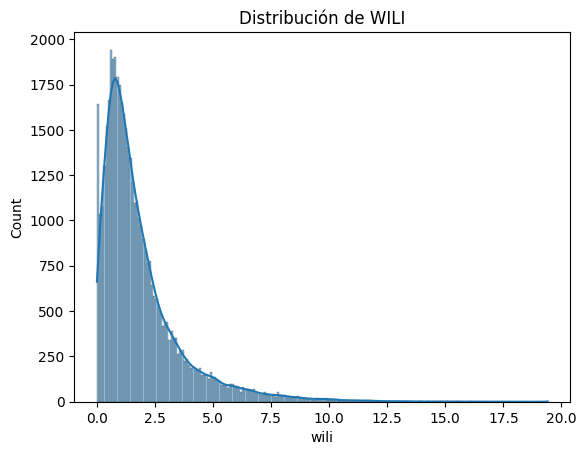

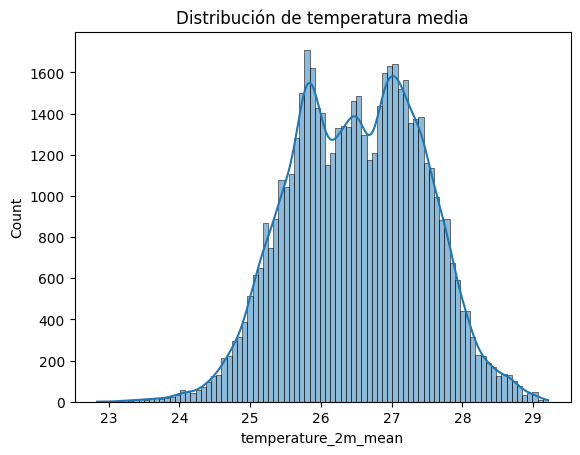

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de wili
sns.histplot(df["wili"].dropna(), kde=True)
plt.title("Distribución de WILI")
plt.show()

# Temperatura media
sns.histplot(df["temperature_2m_mean"].dropna(), kde=True)
plt.title("Distribución de temperatura media")
plt.show()

El gráfico muestra la distribución de la variable wili, que representa el porcentaje ponderado de visitas por enfermedades similares a la gripe (Influenza-Like Illness, ILI) en clínicas de EE.UU.

* Distribución sesgada a la derecha
* La mayoría de los valores de wili están concentrados entre 0 y 2.5.
* Hay una cola larga hacia la derecha, indicando que en algunos casos se han registrado valores más altos de incidencia de gripe.
* Esto sugiere que la gripe suele mantenerse en niveles bajos, con algunos picos de mayor incidencia en ciertas semanas.

Análisis del gráfico de Distribución de la Temperatura Media: 

* En contraste, la temperatura media sigue una distribución más normal y simétrica con una ligera tendencia bimodal.
* La temperatura oscila principalmente entre 24°C y 29°C, con una mayor frecuencia alrededor de los 26-27°C.
* Esto indica que la variabilidad de la temperatura es más controlada en comparación con wili, que tiene una mayor dispersión.

## Variables Numéricas

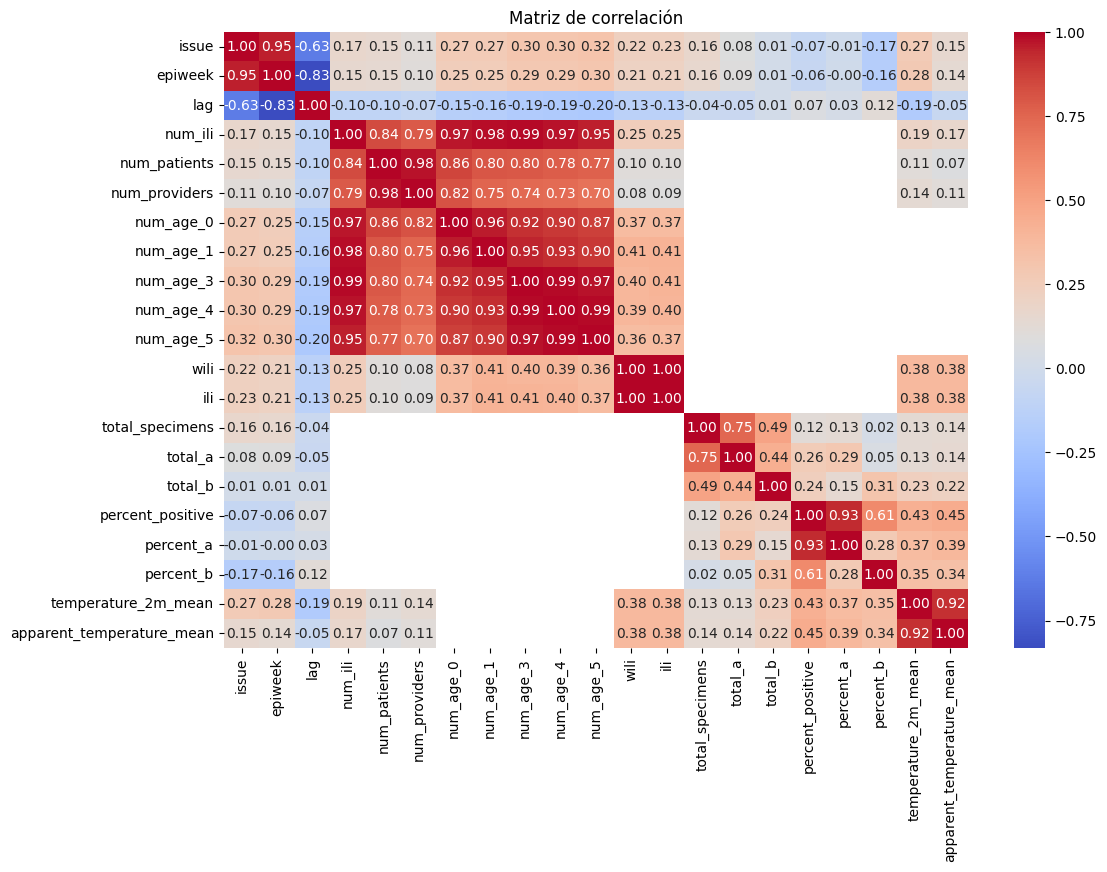

In [11]:
# Solo variables numéricas
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
cor_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(cor_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

## Correlación de Variables

In [12]:
# Verificar que las columnas necesarias existen y no tienen valores nulos
df_filtered = df[['wili', 'temperature_2m_mean']].dropna()

# Calcular la correlación de Pearson
correlation = df_filtered.corr().iloc[0, 1]
correlation

np.float64(0.3805555222912494)

El coeficiente de correlación de Pearson es 0.38, lo que indica una correlación positiva moderada entre la incidencia de gripe (wili) y la temperatura media (temperature_2m_mean).

OBservaciones: 

A medida que la temperatura aumenta, wili tiende a aumentar ligeramente, pero la relación no es muy fuerte.

Esto sugiere que la temperatura podría influir en los casos de gripe, pero otros factores también son importantes

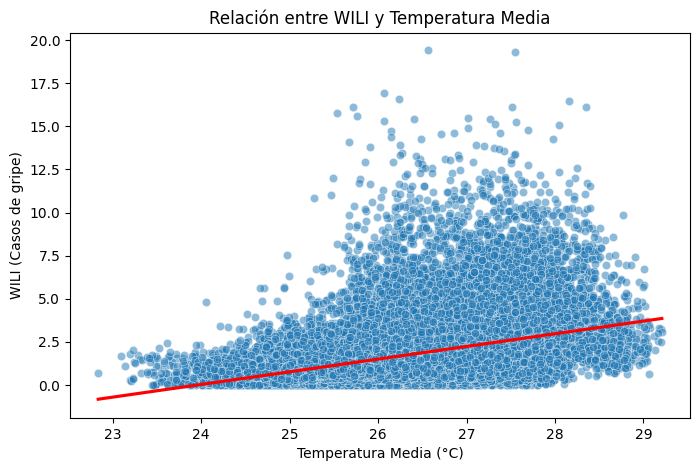

,Estacion,Variable,Correlación
0,Otoño,wili,0.380556


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el scatter plot entre WILI y temperatura media
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_filtered['temperature_2m_mean'], y=df_filtered['wili'], alpha=0.5)
sns.regplot(x=df_filtered['temperature_2m_mean'], y=df_filtered['wili'], scatter=False, color='red')

plt.xlabel("Temperatura Media (°C)")
plt.ylabel("WILI (Casos de gripe)")
plt.title("Relación entre WILI y Temperatura Media")
plt.show()

# Crear una nueva columna para la estación del año basada en epiweek
def get_season(epiweek):
    if 1 <= epiweek <= 13:  # Invierno (Semanas 1 a 13)
        return "Invierno"
    elif 14 <= epiweek <= 26:  # Primavera (Semanas 14 a 26)
        return "Primavera"
    elif 27 <= epiweek <= 39:  # Verano (Semanas 27 a 39)
        return "Verano"
    else:  # Otoño (Semanas 40 a 52)
        return "Otoño"

df["Estacion"] = df["epiweek"].apply(get_season)

# Calcular la correlación por estación
correlation_by_season = df.groupby("Estacion")[["wili", "temperature_2m_mean"]].corr().iloc[0::2, 1].reset_index()
correlation_by_season.columns = ["Estacion", "Variable", "Correlación"]
correlation_by_season